In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import zipfile
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve

zf = zipfile.ZipFile("bank-additional.zip") 
df = pd.read_csv(zf.open("bank-additional/bank-additional.csv"), sep = ";")
df.shape

(4119, 21)

In [4]:
df.isnull().sum().sum() # no NAs

## looking at numeric variables summary stats
df.describe()

age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count   4119.000000     4119.000000    4119.000000  4119.000000  4119.000000  
mean       0.084972       93.579704     -40.499102     3.621356  5166.481695  
std        1.563114        0.579349       4.594578     1.733591    73.667904  
min       -3.400000       92.201000     -50.800000     0.635000  4963.600000  
25%       -1.800000       93.075000     -42.700000     1.334000  5099.100000  
50%        1.100000       93.749000     -41.800000     4.857000  5191.000000  
75%        1.400000       93.994000     -36.400000     4.961000  5228.100000  
max        1.400000       94.767000     -26.900000     5.045000  5228.100000

In [5]:
## counts
df.groupby("y").size()

num_cols = list(df.select_dtypes(np.number).columns)
print(num_cols)

obj_cols = list(df.select_dtypes(object).drop("y", axis = 1).columns)
print(obj_cols)

df[obj_cols + ["y"]].groupby("y").agg(["nunique"])

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


job marital education default housing    loan contact   month  \
    nunique nunique   nunique nunique nunique nunique nunique nunique   
y                                                                       
no       12       4         8       3       3       3       2      10   
yes      12       4         7       2       3       3       2      10   

    day_of_week poutcome  
        nunique  nunique  
y                         
no            5        3  
yes           5        3

In [6]:
## change classes to float
df["y"] = np.where(df["y"] == "yes", 1., 0.)

## the pipeline
scaler = Pipeline(steps = [
    ## there are no NAs anyways
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])

encoder = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "constant", fill_value = "missing")),
    ("onehot", OneHotEncoder(handle_unknown = "ignore")),
])

preprocessor = ColumnTransformer(
    transformers = [
        ("num", scaler, num_cols),
        ("cat", encoder, obj_cols)
])

pipe = Pipeline(steps = [("preprocessor", preprocessor)])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis = 1), df.y, 
    stratify = df.y, 
    random_state = 13, 
    test_size = 0.25)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [8]:
## getting feature names from the pipeline
nums = pipe["preprocessor"].transformers_[0][2]
obj = list(pipe["preprocessor"].transformers_[1][1]["onehot"].get_feature_names(obj_cols))
fnames = nums + obj
len(fnames) ## new number of columns due to one hot encoder

62

['month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']


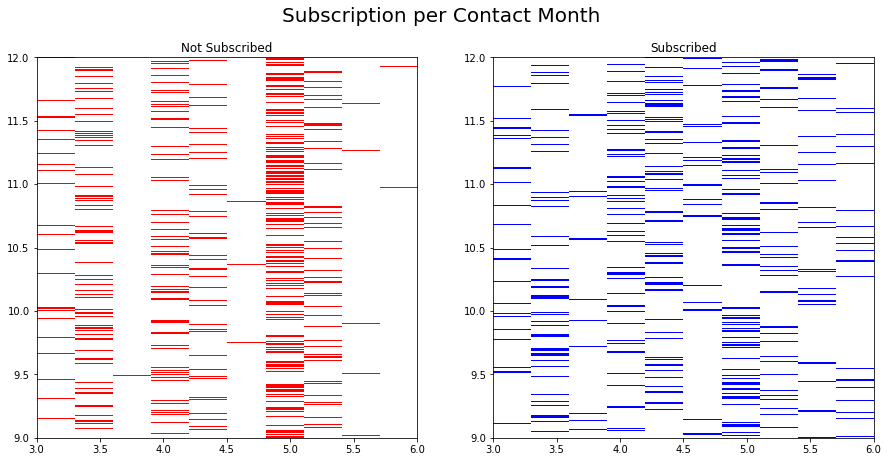

In [9]:
from matplotlib.colors import ListedColormap

print([i for i in obj if "month" in i])

## filter the train data on the month data
tr = X_train[:, [True if "month" in i else False for i in fnames]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))
fig.suptitle("Subscription per Contact Month", fontsize = 20)
cmapmine1 = ListedColormap(["w", "r"], N = 2)
cmapmine2 = ListedColormap(["w", "b"], N = 2)

ax1.imshow(tr[y_train == 0.0], cmap = cmapmine1, interpolation = "none", extent = [3, 6, 9, 12])
ax1.set_title("Not Subscribed")

ax2.imshow(tr[y_train == 1.0], cmap = cmapmine2, interpolation = "none", extent = [3, 6, 9, 12])
ax2.set_title("Subscribed")

plt.show()

In [10]:
clf = LogisticRegression(
    solver = "newton-cg", max_iter = 50, C = .1, penalty = "l2"
)

clf.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=50, solver='newton-cg')

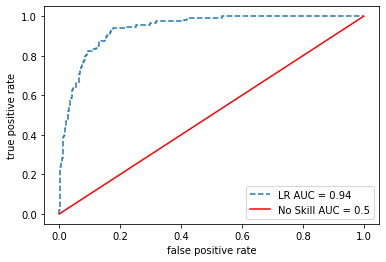

In [11]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, ls = "--", label = "LR AUC = %0.2f" % roc_auc)
plt.plot([0,1], [0,1], c = "r", label = "No Skill AUC = 0.5")
plt.legend(loc = "lower right")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.show()

<AxesSubplot:xlabel='threshold', ylabel='value'>

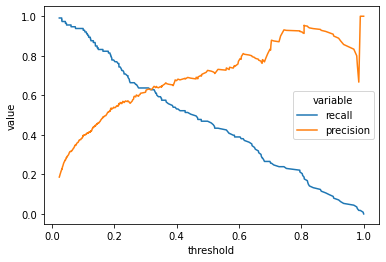

In [12]:
precision, recall, threshold = precision_recall_curve(
    y_test, y_pred_proba)
tst_prt = pd.DataFrame({
    "threshold": threshold,
    "recall": recall[1:],
    "precision": precision[1:]
})
tst_prt_melted = pd.melt(tst_prt, id_vars = ["threshold"],
                         value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value",
             hue = "variable", data = tst_prt_melted)

In [13]:
y_pred = np.zeros(len(y_test))
y_pred[y_pred_proba >= 0.3] = 1.

print("Accuracy: %.2f%%" % (100 * accuracy_score(y_test, y_pred)))
print("Precision: %.2f%%" % (100 * precision_score(y_test, y_pred)))
print("Recall: %.2f%%" % (100 * recall_score(y_test, y_pred)))

Accuracy: 91.65%
Precision: 61.54%
Recall: 63.72%


In [14]:
explainer = shap.Explainer(clf, X_train, feature_names = np.array(fnames))
shap_values = explainer(X_test)

In [15]:
shap.initjs()

In [16]:
ind = np.argmax(y_test == 0)
print("actual is:", y_test.values[ind], "while pred is:", y_pred[ind])
shap.plots.force(shap_values[ind])

actual is: 0.0 while pred is: 0.0


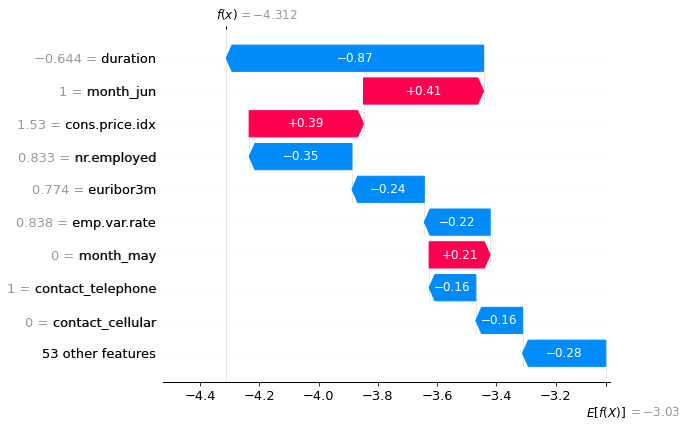

In [17]:
shap.plots.waterfall(shap_values[ind])

In [18]:
ind = np.argmax(y_test == 1)
print("actual is:", y_test.values[ind], "while pred is:", y_pred[ind])
shap.plots.force(shap_values[ind])

actual is: 1.0 while pred is: 1.0


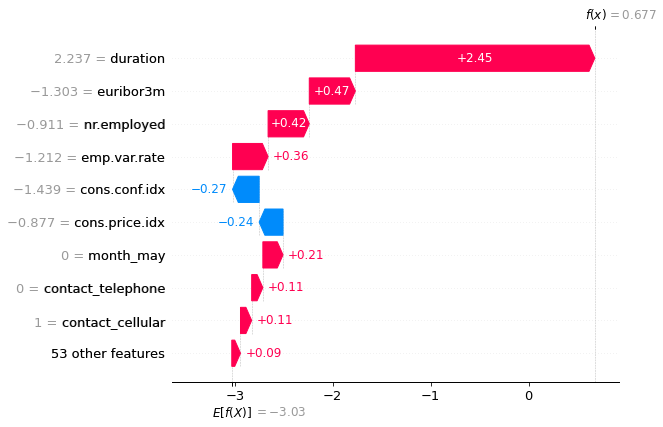

In [19]:
shap.plots.waterfall(shap_values[ind])

In [20]:
shap.force_plot(explainer.expected_value, shap_values.values, X_test, feature_names = fnames)

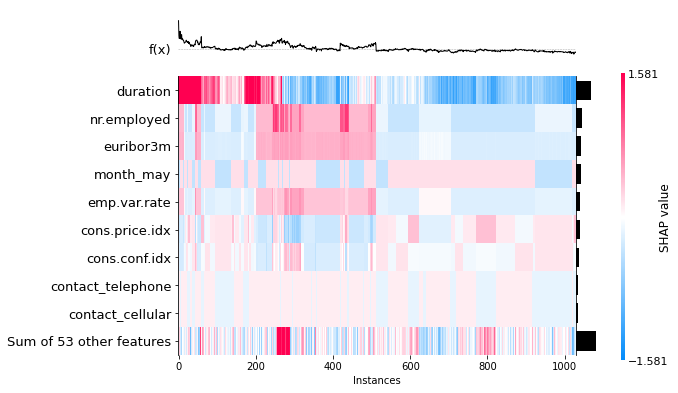

In [21]:
shap.plots.heatmap(shap_values)

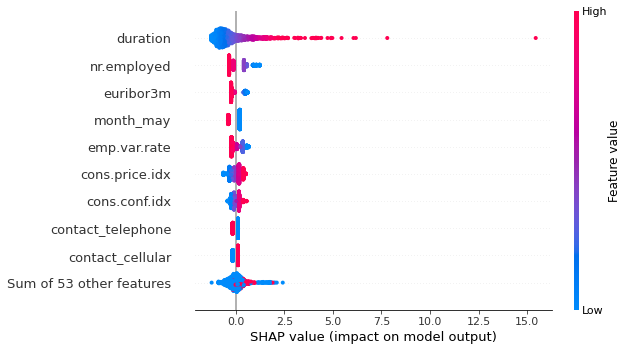

In [22]:
shap.plots.beeswarm(shap_values)

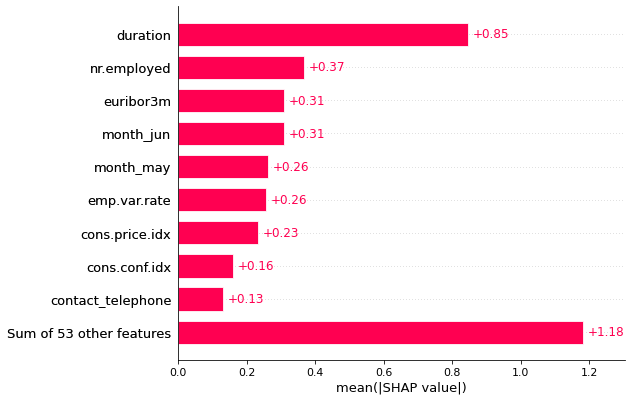

In [23]:
shap.plots.bar(shap_values)